In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random


import tensorflow as tf
from keras.utils import to_categorical
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.models import Sequential
from keras.layers import Convolution2D, BatchNormalization , Activation, AveragePooling2D, GlobalAveragePooling2D 
from keras.layers import  Dropout, Flatten, Dense

import warnings
warnings.filterwarnings("ignore")


from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter


In [2]:
path = '../facial-expression-recognition/Data/'
os.listdir(path)

['face_data.csv', 'test.csv', 'train.csv']

In [3]:
data = pd.read_csv(path+'face_data.csv')

In [4]:
data

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
data[' Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [7]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [8]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

[Text(0, 0, 'Angry'),
 Text(1, 0, 'Disgust'),
 Text(2, 0, 'Fear'),
 Text(3, 0, 'Happy'),
 Text(4, 0, 'Sad'),
 Text(5, 0, 'Surprise'),
 Text(6, 0, 'Neutral')]

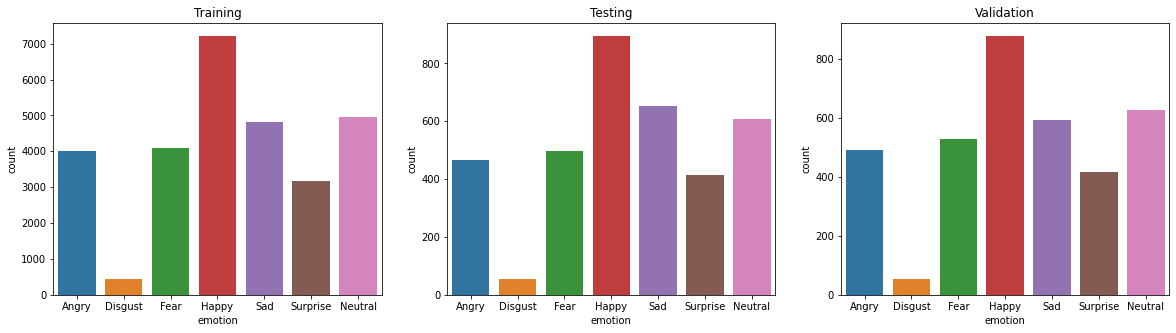

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
sns.countplot(data = data[data[' Usage']=='Training'], x='emotion', ax=ax1).set_title('Training')
ax1.set_xticklabels(emotions.values())
sns.countplot(data = data[data[' Usage']=='PublicTest'], x='emotion', ax=ax2).set_title('Testing')
ax2.set_xticklabels(emotions.values())
sns.countplot(data = data[data[' Usage']=='PrivateTest'], x='emotion', ax=ax3).set_title('Validation')
ax3.set_xticklabels(emotions.values())

<h1 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
        Definition of functions  
</font>
</h1>

<h3 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
          We define some helper functions for preparing and ploting the data


</font>
</h3>



In [10]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels and pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_emotions(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    # Function to plot the image and compare the prediction results with the label 
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='#B2B2B2', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='#146C94')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index(), color='#526D82')
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [11]:
emotions.values()

dict_values(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

<h1 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
      Define training, validation and test data

</font>
</h1>


 



In [12]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [13]:
train_image_array.shape, val_image_array.shape, test_image_array.shape

((28709, 48, 48), (3589, 48, 48), (3589, 48, 48))

In [14]:
print(train_image_array[100])
print(train_image_label[100])

[[162. 161. 159. ... 131. 122. 105.]
 [148. 155. 160. ... 131. 123. 120.]
 [142. 148. 154. ... 125. 124. 120.]
 ...
 [177. 155. 134. ... 194. 194. 193.]
 [185. 179. 143. ... 201. 202. 201.]
 [207. 187. 154. ... 192. 193. 196.]]
3


<h2 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
       Count emotions
</font>
</h2>




In [15]:
print(Counter(train_image_label))

Counter({3: 7215, 6: 4965, 4: 4830, 2: 4097, 0: 3995, 5: 3171, 1: 436})


<h1 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
     Reshape and scale the images   

</font>
</h1>




In [16]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255


<h1 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
     Encoding of the target value

</font>
</h1>




In [17]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [18]:
train_labels[100]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
       Some Examples Emotions

</font>
</h1>





 <h1 align=center style="line-height:00%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
    ALL Emotions 
</font>
</h1>




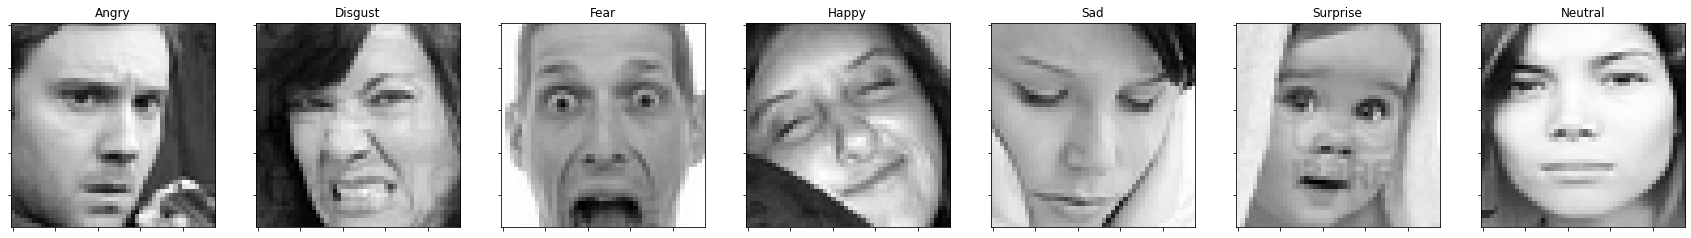

In [19]:
plot_all_emotions()

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
     Happy
</font>
</h1>


 

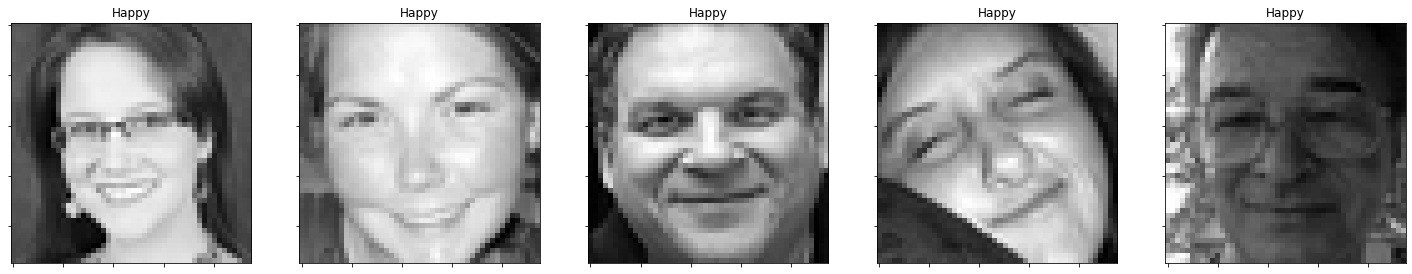

In [20]:
plot_emotions(label=3)

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
     Surprise
</font>
</h1>


 

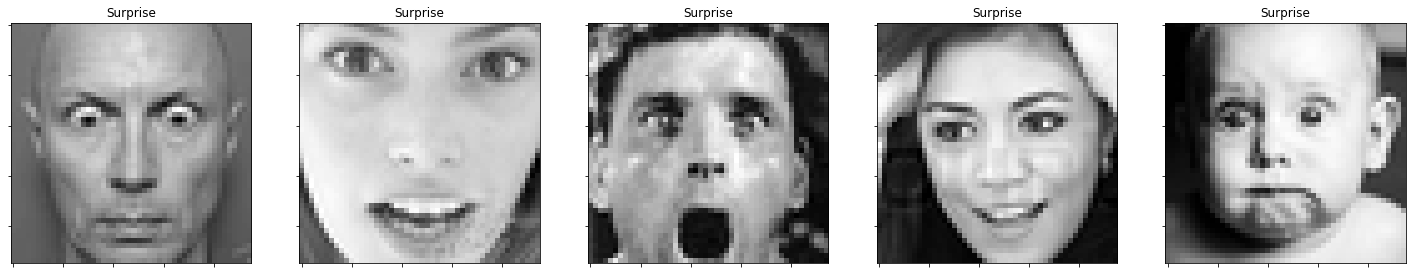

In [21]:
plot_emotions(label=5)

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
    Angry  
</font>
</h1>




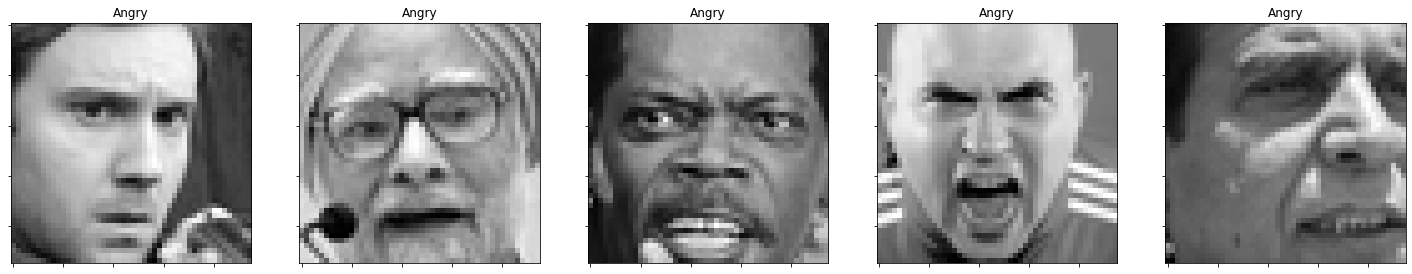

In [22]:
plot_emotions(label=0)

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
  Disgust
</font>
</h1>





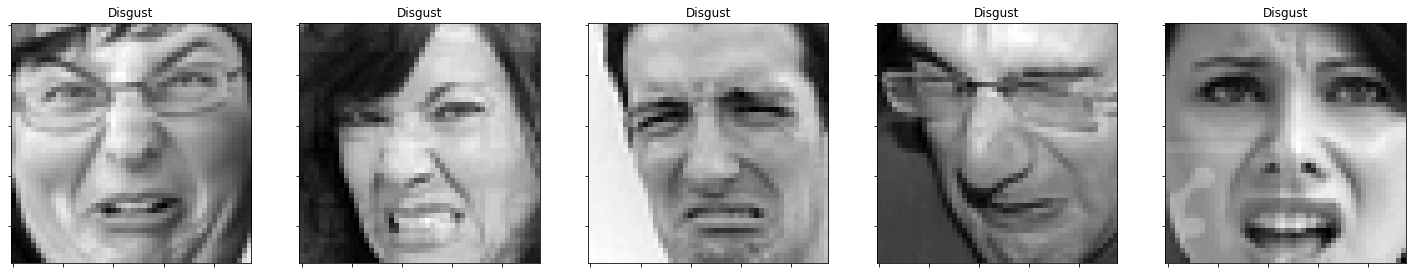

In [23]:
plot_emotions(label=1)

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
     Fear
</font>
</h1>




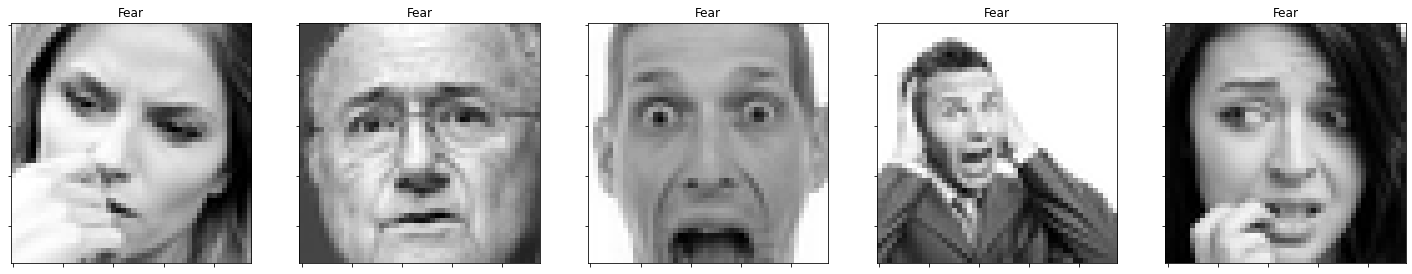

In [24]:
plot_emotions(label=2)

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
      Sad
</font>
</h1>






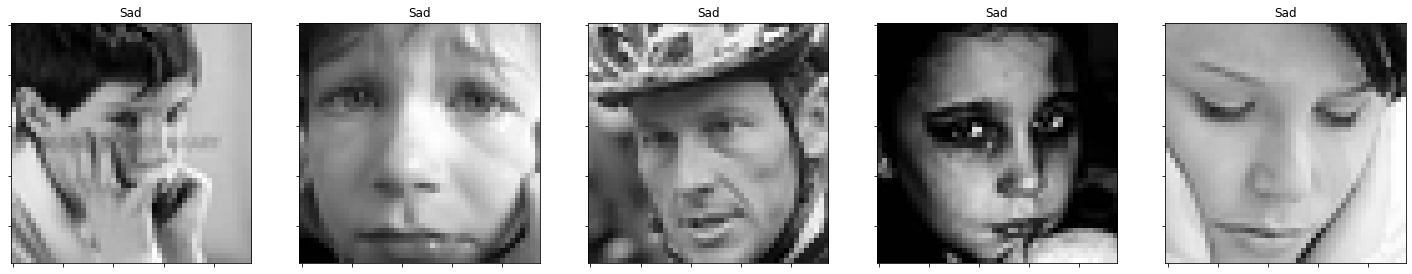

In [25]:
plot_emotions(label=4)

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
     Neutral
</font>
</h1>




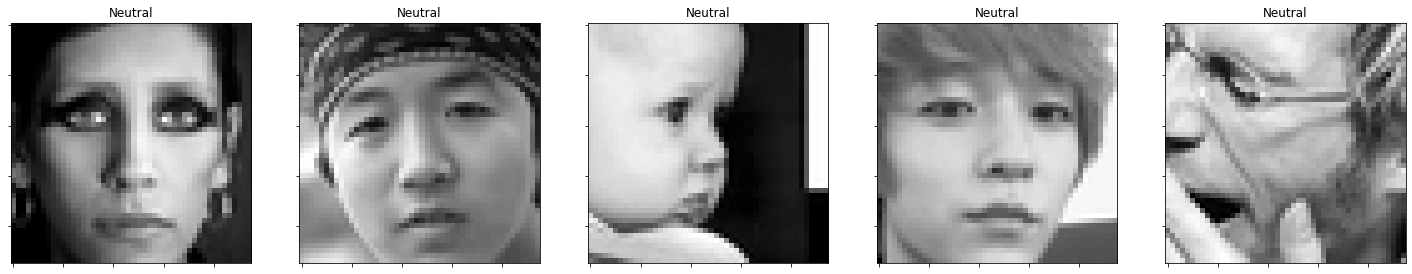

In [26]:
plot_emotions(label=6)

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
    Distribution Of Labels  
</font>
</h1>




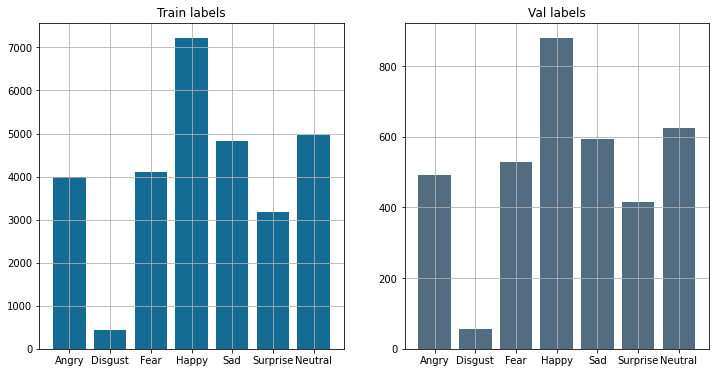

In [27]:
compare_distributions(train_labels, val_labels, title1='Train labels', title2='Val labels')

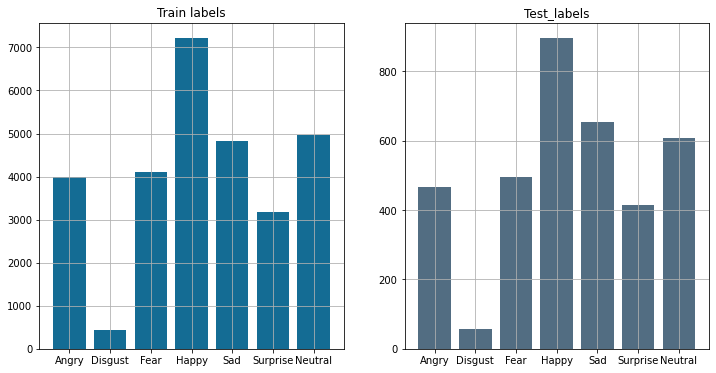

In [28]:
compare_distributions(train_labels, test_labels, title1='Train labels', title2='Test_labels')

<h1 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
    Class Weights
</font>
</h1>



In [29]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [30]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
    CNN Model
</font>
</h1>





In [31]:
input_shape=(48, 48,1)
num_classes = 7

In [32]:
""" Building up Model Architecture """

model = Sequential()
model.add(Convolution2D(filters=32, kernel_size=(7, 7), padding='same',
                            name='image_array', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=64, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=512, kernel_size=(3, 3), padding='same'))



model.add(BatchNormalization())
model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax',name='predictions'))


In [33]:
# parameters
batch_size = 32 #Number of samples per gradient update
num_epochs = 200 # Number of epochs to train the model.
#input_shape = (64, 64, 1)
verbose = 1 #per epohs  progress bar
num_classes = 7 
patience = 50

In [34]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
      Data Augmenttion
</font>
</h1>





In [35]:

""" Data Augmentation => taking the batch and apply some series of random transformations (random rotation, resizing, shearing) 

      ===> to increase generalizability of model  """


# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [36]:

# model parameters/compilation

""" CONFIGURATION ==>.compile(optimizer, loss , metrics) """



model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 32)        1600      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 24, 24, 32)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 64)        5

In [37]:
datasets = ['face_data']
num_epochs = 40
base_path="content"
for dataset_name in datasets:
    print('Training dataset:', dataset_name)

    #callbacks
    log_file_path = dataset_name + '_emotion_training.log'

    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_loss', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,patience=int(patience/4), verbose=1)
    
    trained_models_path = os.path.join(base_path,"face_data",'simple_cnn')
    trained_models_path
    model_names =os.path.join(base_path,"face_data",'simple_cnn','.{epoch:02d}-{val_loss:.2f}.hdf5') 
    
    # if error "acc" in 1 line ... don't confuse check entire block since fit() generates a inner loop
    model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
    my_callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

    # loading dataset
    history=model.fit_generator(data_generator.flow(train_images, train_labels,
                                            batch_size),
                                           epochs=num_epochs, 
                                           verbose=1,
                                           callbacks=my_callbacks,
                                          validation_data =(val_images, val_labels) )  
                                          #not callbacks = [my_callbacks] since we my_callbacks is already a list 


Training dataset: face_data
Epoch 1/40
898/898 [==============================] - ETA: 0s - loss: 1.8181 - accuracy: 0.2703
Epoch 1: val_loss improved from inf to 1.66619, saving model to content\face_data\simple_cnn\.01-1.67.hdf5
898/898 [==============================] - 339s 377ms/step - loss: 1.8181 - accuracy: 0.2703 - val_loss: 1.6662 - val_accuracy: 0.3469 - lr: 0.0010
Epoch 2/40
898/898 [==============================] - ETA: 0s - loss: 1.6747 - accuracy: 0.3386
Epoch 2: val_loss did not improve from 1.66619
898/898 [==============================] - 343s 381ms/step - loss: 1.6747 - accuracy: 0.3386 - val_loss: 1.6662 - val_accuracy: 0.3357 - lr: 0.0010
Epoch 3/40
898/898 [==============================] - ETA: 0s - loss: 1.6164 - accuracy: 0.3649
Epoch 3: val_loss did not improve from 1.66619
898/898 [==============================] - 340s 379ms/step - loss: 1.6164 - accuracy: 0.3649 - val_loss: 1.6961 - val_accuracy: 0.3753 - lr: 0.0010
Epoch 4/40
898/898 [===================

Epoch 27/40
898/898 [==============================] - ETA: 0s - loss: 1.2349 - accuracy: 0.5317
Epoch 27: val_loss did not improve from 1.12255
898/898 [==============================] - 371s 413ms/step - loss: 1.2349 - accuracy: 0.5317 - val_loss: 1.1609 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 28/40
898/898 [==============================] - ETA: 0s - loss: 1.2298 - accuracy: 0.5309
Epoch 28: val_loss did not improve from 1.12255
898/898 [==============================] - 372s 414ms/step - loss: 1.2298 - accuracy: 0.5309 - val_loss: 1.3269 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 29/40
898/898 [==============================] - ETA: 0s - loss: 1.2299 - accuracy: 0.5341
Epoch 29: val_loss did not improve from 1.12255
898/898 [==============================] - 370s 412ms/step - loss: 1.2299 - accuracy: 0.5341 - val_loss: 1.1457 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 30/40
898/898 [==============================] - ETA: 0s - loss: 1.2227 - accuracy: 0.5348
Epoch 30: val_loss did n

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

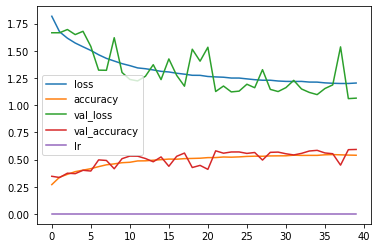

In [39]:
for key in history.history.keys():
    plt.plot(history.history[key], label=key)
plt.legend()

<h1 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
Evaluate
</font>
</h1>




In [40]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy  :', test_acc*100)
print('Test  loss     :', test_loss)

113/113 [==============================] - 9s 77ms/step - loss: 1.0968 - accuracy: 0.5904
Test accuracy  : 59.04151797294617
Test  loss     : 1.0967527627944946


In [130]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 12s 105ms/step


In [42]:
pred_test_labels[0]

array([0.2673081 , 0.01363401, 0.1247563 , 0.17101452, 0.11422084,
       0.05921904, 0.24984719], dtype=float32)

 <h1 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
f1_score
</font>
</h1>


In [72]:
import numpy as np
from sklearn.metrics import f1_score

# Assuming you have one-hot encoded labels for test data
# Convert them back to integer labels
test_labels_int = np.argmax(test_labels, axis=1)
pred_test_labels_int = np.argmax(pred_test_labels, axis=1)

# Calculate the F1-score using the 'macro' averaging
f1_macro = f1_score(test_labels_int, pred_test_labels_int, average='macro')

print("F1-score :", f1_macro)

F1-score (macro): 0.5261473352571242


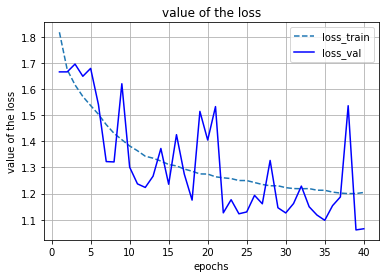

In [43]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, '--', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss')
plt.xlabel('epochs')
plt.ylabel('value of the loss')
plt.legend()
plt.grid()
plt.show()

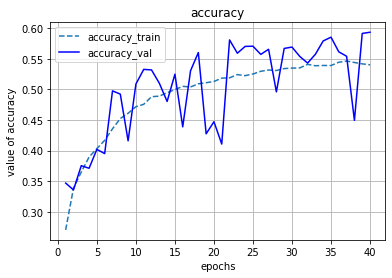

In [44]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, '--', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
---------------------------- Analysis of the results ----------------------------
</font>
</h1>





<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
    Predicted Label Comparision Plot

</font>
</h1>







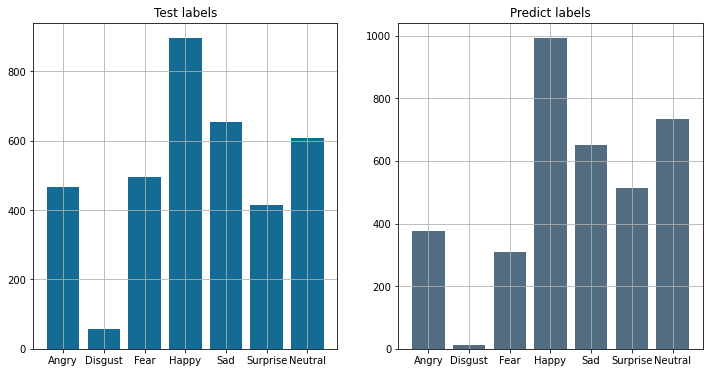

In [50]:
compare_distributions(test_labels, pred_test_labels, title1='Test labels', title2='Predict labels')

In [45]:
total_elements = np.array(pred_test_labels)
last_index = len(total_elements) - 1
last_index

3588

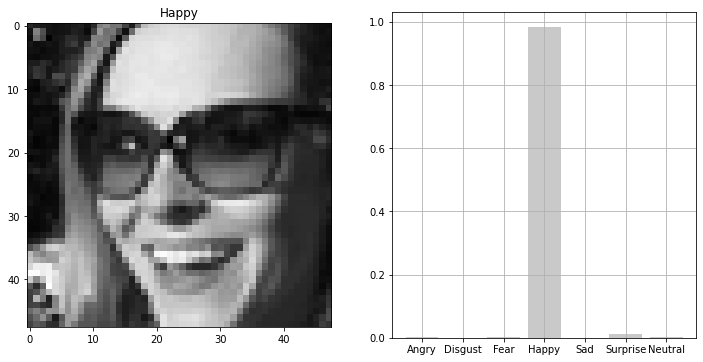

In [158]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, random.randint(0, last_index))


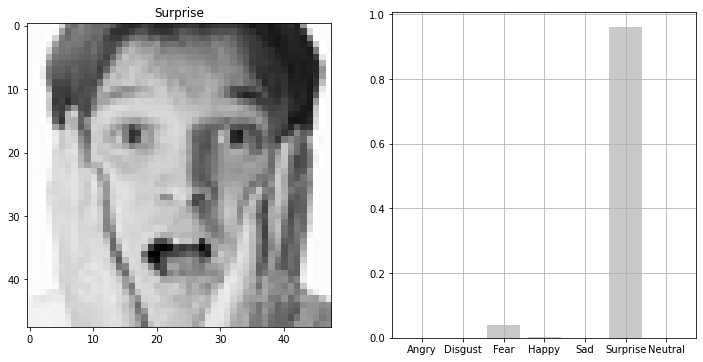

In [144]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, random.randint(0, last_index))


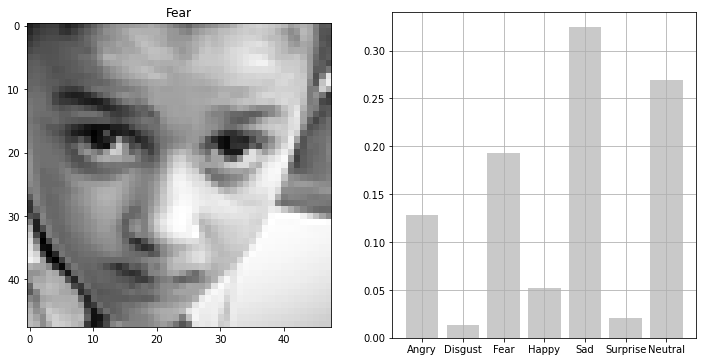

In [137]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, random.randint(0, last_index))


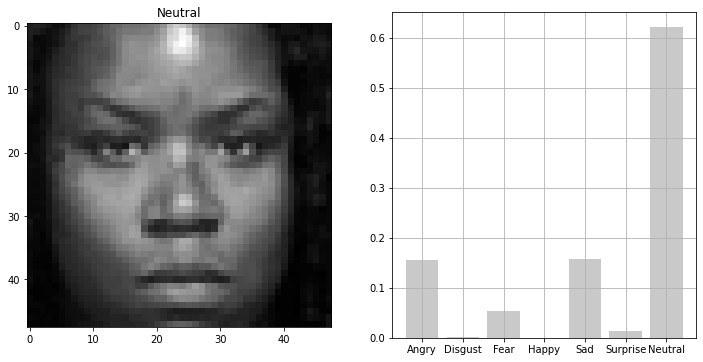

In [143]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels,random.randint(0, last_index))


 <h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
Testing the model on some images
</font>
</h1>




In [51]:
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
#emojis unicodes 
emojis = { 0:"\U0001f620",1:"\U0001f922" ,2:"\U0001f628" ,3:"\U0001f60A" , 4:"\U0001f625" ,5:"\U0001f632",6:"\U0001f610"}

In [52]:
print(emojis.values(),sep=" ")

dict_values(['😠', '🤢', '😨', '😊', '😥', '😲', '😐'])


In [53]:
import cv2
import os
import numpy as np

def _predict(path):
    data_dir = 'content'
    haarcascadepath = os.path.join('content', 'haarcascade_frontalface_default.xml')
    facecasc = cv2.CascadeClassifier(haarcascadepath)
    imagePath = os.path.join('content', 'images', path)
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=10)
    print("No of faces : ",len(faces))

    i = 1
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]  # cropping
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        print("person ", i, " : ", emotion_dict[maxindex], "-->", emojis[maxindex])
        cv2.putText(image, emotion_dict[maxindex], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (245, 200, 255), 2)
                                                      #if text is not apeared , change coordinates. it may work


    # Resize the image to a larger size before displaying
    resized_image = cv2.resize(image, (2000, 1800))
    # Use matplotlib to display the resized image
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()



No of faces :  2
1/1 [==============================] - 0s 249ms/step
person  1  :  Happy --> 😊
1/1 [==============================] - 0s 27ms/step
person  1  :  Happy --> 😊


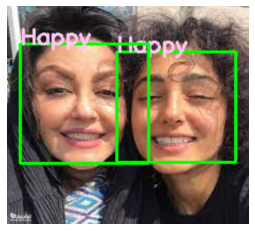

In [159]:
_predict("gol.jpg")

No of faces :  1
1/1 [==============================] - 0s 28ms/step
person  1  :  Angry --> 😠


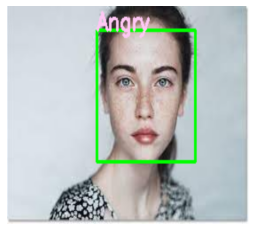

In [160]:
_predict("images.jpg")

No of faces :  1
1/1 [==============================] - 0s 32ms/step
person  1  :  Sad --> 😥


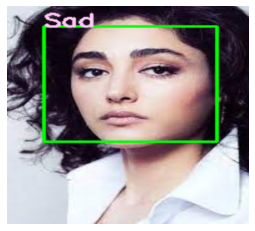

In [57]:
_predict("download (3).jpg")

No of faces :  1
1/1 [==============================] - 0s 38ms/step
person  1  :  Fear --> 😨


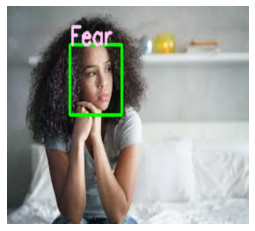

In [163]:
_predict("dep.jpg")

No of faces :  1
1/1 [==============================] - 0s 63ms/step
person  1  :  Happy --> 😊


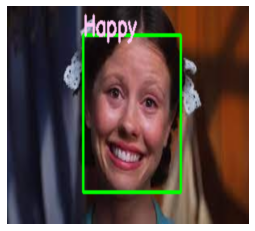

In [164]:
_predict("happy.jpg")

No of faces :  1
1/1 [==============================] - 0s 36ms/step
person  1  :  Angry --> 😠


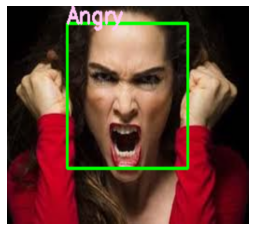

In [165]:
_predict("img.jpg")

No of faces :  4
1/1 [==============================] - 0s 28ms/step
person  1  :  Neutral --> 😐
1/1 [==============================] - 0s 31ms/step
person  1  :  Happy --> 😊
1/1 [==============================] - 0s 37ms/step
person  1  :  Happy --> 😊
1/1 [==============================] - 0s 31ms/step
person  1  :  Fear --> 😨


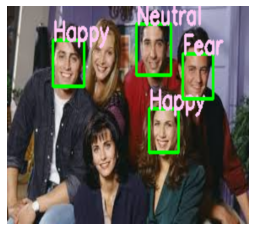

In [65]:
_predict("friends1.jpg")

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
---------------------------- Wrong Prediction ----------------------------
</font>
</h1>








In [111]:
df_compare = pd.DataFrame()
df_compare['Actual'] = test_labels.argmax(axis=1)
df_compare['Predicted'] = pred_test_labels.argmax(axis=1)


In [112]:

df_compare['Actual'] = df_compare['Actual'].replace({0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'})
df_compare['Predicted']=df_compare['Predicted'].replace({0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'})


In [115]:
def highlight_equal(row):
    if row['Actual'] == row['Predicted']:
        return ['background-color: #59a5d8; color: white'] * 2
    else:
        return ['background-color: #d80032; color: white'] * 2

df_compare.sample(10).style.apply(highlight_equal, axis=1).set_properties(**{
    'font-family': 'Lucida Calligraphy',
    'color': 'LigntGreen',
    'font-size': '15px'
})




,Actual,Predicted
1558,Happy,Happy
3486,Sad,Neutral
2328,Surprise,Surprise
2285,Sad,Angry
693,Surprise,Angry
1526,Angry,Fear
2495,Fear,Fear
3306,Sad,Sad
2207,Neutral,Neutral
1772,Neutral,Happy


<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
 Confusion Matrix 
</font>
</h1>






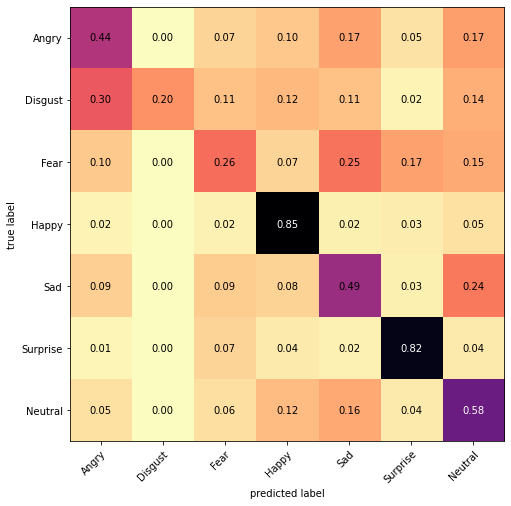

In [116]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                cmap= "magma_r",
                                figsize=(8, 8))
fig.show()

<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
    ROC Curve
</font>
</h1>






In [117]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle

In [118]:
new_label =  ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [119]:
final_label = new_label
new_class = 7

In [120]:
#ravel flatten the array into single vector
y_pred_ravel = df_compare['Predicted'].ravel()
lw = 2

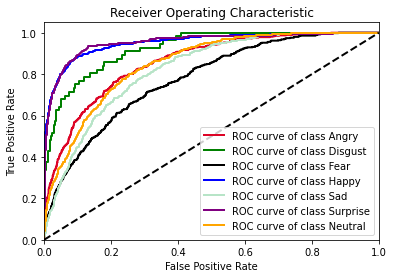

In [121]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:,i], pred_test_labels[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#colors = cycle(['red', 'green','black'])
colors = cycle(['#dd0426', 'green','black','blue', '#b7e4c7','purple','orange'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

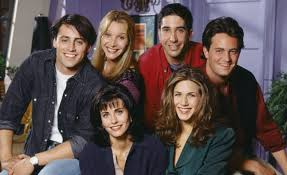

In [122]:

""" code snippet to display image """

from IPython.display import Image
imagePath = os.path.join('content', 'images', 'friends1.jpg')

Image(imagePath)

<h3 align=left style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#146C94">
    Saving the weights of the model and again loading it in keras
    <br>
    saving the architecture of the model in json file using model_from_json
</font>
</h3>

In [151]:
# Save the model's weights to an HDF5 file (optional, but recommended)
model.save_weights("model.h5")

In [152]:
model.load_weights("model.h5")

In [153]:
from keras.models import model_from_json

In [154]:
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model_architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")


Saved model to disk


In [155]:
""" loading the model in modular approach """

def load_model_():
    json_file = open('model_architecture.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("model.h5")
    return model


model = load_model_()

In [156]:
model2 = load_model_()